## Is it possible to predict how betting odds will change, by using predicted polling data?

In [1]:
import requests
import numpy as np
import pandas as pd
from realclearpolling import *
from datetime import datetime, timedelta

In [2]:
url = 'https://www.realclearpolitics.com/json/odds/event_106_final.json?'
response = requests.get(url)
data = response.json()
print(data)

{'poll': {'rcp_avg': [{'date_r': 'Thu, 11 Apr 2024 00:00:00 -0400', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '42.4'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '42.2'}, {'id': '2473', 'name': 'Robert Kennedy Jr', 'color': '#993300', 'value': '3.8'}, {'id': '2094', 'name': 'Gavin Newsom', 'color': '#7381C9', 'value': '3.3'}, {'id': '2244', 'name': 'Michelle Obama', 'color': '#c3c3de', 'value': '3.0'}, {'id': '2092', 'name': 'Kamala Harris', 'color': '#00e4ff', 'value': '2.2'}, {'id': '2086', 'name': 'Nikki Haley', 'color': '#bf40b0', 'value': '2.0'}, {'id': '2564', 'name': 'Dean Phillips', 'color': '#37aac7', 'value': '0.3'}, {'id': '2083', 'name': 'Ron DeSantis', 'color': '#154734', 'value': '0.0'}]}, {'date_r': 'Wed, 10 Apr 2024 00:00:00 -0400', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '43.0'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '41.6'}, {'id': '2473

In [3]:
def get_candidate_odds(data, candidate):
    nlist = []
    for i in range(len(data)):
        values = data[i]['candidates']
        for value in values:
            if value['name'] == candidate:
                nlist.append(value['value'])
    return nlist 

def get_dates(data):
    nlist = []
    for i in range(len(data)):
        nlist.append(data[i]['date_r'])
    return nlist

dates = get_dates(data['poll']['rcp_avg'])
trump_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Donald Trump')
biden_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Joe Biden')

In [4]:
# Make a dataframe with dates, Trump odds, Biden odds
df = pd.DataFrame({'date': dates, 'trump': trump_odds, 'biden': biden_odds})
df['date'] = pd.to_datetime(df['date'],utc=True)
df['date'] = df['date'].dt.date
df['biden_rolling'] = df['biden'].rolling(window=1).mean()
df['trump_rolling'] = df['trump'].rolling(window=1).mean()
df.sort_values(by='date', inplace=True)
df

,date,trump,biden,biden_rolling,trump_rolling
460,2023-01-03,14.3,27.7,27.7,14.3
459,2023-01-04,14.6,28.0,28.0,14.6
458,2023-01-05,15.2,28.0,28.0,15.2
457,2023-01-06,14.8,28.0,28.0,14.8
456,2023-01-09,15.2,27.4,27.4,15.2
...,...,...,...,...,...
4,2024-04-07,43.6,41.0,41.0,43.6
3,2024-04-08,42.8,40.6,40.6,42.8
2,2024-04-09,43.4,41.2,41.2,43.4
1,2024-04-10,43.0,41.6,41.6,43.0


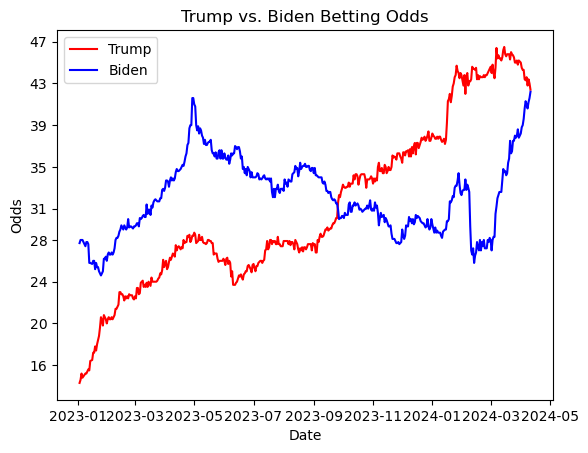

In [5]:
# Plot the odds as a time series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# Use AutoDateLocator to set a reasonable date format
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump',color = 'red')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden', color = 'blue')
ax.set_xlabel('Date')
ax.set_ylabel('Odds')
ax.set_title('Trump vs. Biden Betting Odds')
ax.legend()
plt.show()

In [6]:
rcp = clean_data(get_poll_data())
rcp.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,Morning Consult,4/5 - 4/7,6236 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6236,2024-04-07,4,2024,462
1,Reuters/Ipsos,4/3 - 4/7,833 RV,4.0,37.0,41.0,Biden+4,-4.0,RV,833,2024-04-07,4,2024,462
2,I&I/TIPP,4/3 - 4/5,1265 RV,2.8,40.0,43.0,Biden+3,-3.0,RV,1265,2024-04-05,4,2024,460
3,Emerson,4/2 - 4/3,1438 RV,2.5,46.0,45.0,Trump+1,1.0,RV,1438,2024-04-03,4,2024,458
4,Rasmussen Reports,3/31 - 4/2,1099 LV,3.0,49.0,41.0,Trump+8,8.0,LV,1099,2024-04-02,4,2024,457


In [7]:
# Plot polling data on a time series

#Is it possible to subset the predictions to only include the unique dates?
dates = rcp["End Date"]
unique_dates = np.unique(dates)

biden_vals = []
trump_vals = []

for date in unique_dates:
    mask = rcp["End Date"] == date
    biden_vals.append(rcp[mask]["Biden (D)"].mean())
    trump_vals.append(rcp[mask]["Trump (R)"].mean())

ndf = pd.DataFrame({'date': unique_dates, 'trump': trump_vals, 'biden': biden_vals})
ndf["Biden Rolling"] = ndf["biden"].rolling(window=5).mean()
ndf["Trump Rolling"] = ndf["trump"].rolling(window=5).mean()
ndf.sort_values(by='date', inplace=True)
ndf.head()



,date,trump,biden,Biden Rolling,Trump Rolling
0,2023-01-16,40.0,46.0,NaN,NaN
1,2023-01-17,42.0,46.0,NaN,NaN
2,2023-01-19,46.0,41.0,NaN,NaN
3,2023-01-20,43.0,40.0,NaN,NaN
4,2023-01-21,44.0,41.0,42.8,43.0


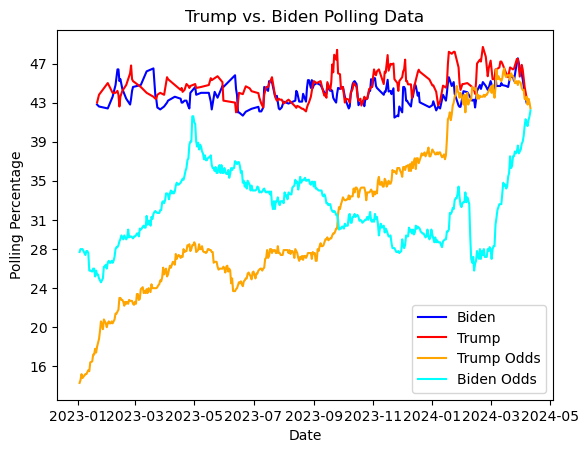

In [8]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'aqua')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

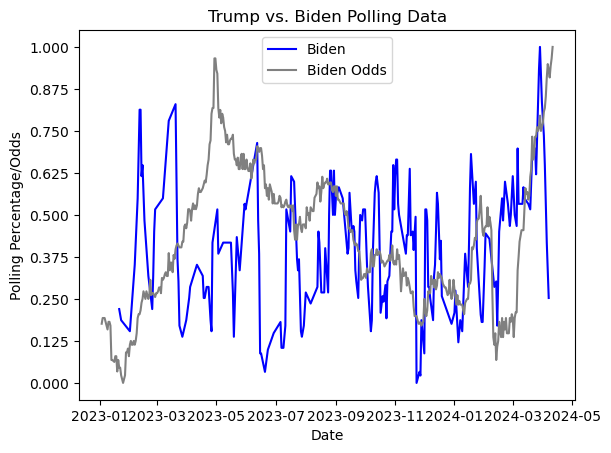

In [9]:
# We should try to rescale the data to be between 0 and 1

# We can use the min-max scaling method to rescale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ndf['Biden Rolling'] = scaler.fit_transform(ndf['Biden Rolling'].values.reshape(-1,1))
ndf['Trump Rolling'] = scaler.fit_transform(ndf['Trump Rolling'].values.reshape(-1,1))
df['biden_rolling'] = scaler.fit_transform(df['biden_rolling'].values.reshape(-1,1))
df['trump_rolling'] = scaler.fit_transform(df['trump_rolling'].values.reshape(-1,1))

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
#plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
#plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'grey')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

## General Observations

It looks like the odds precurse the polls. This makes sense, since odds are based on real time news updates, and polls face lag effects. 

In [10]:
#Let's just try to make a linear regression model that takes day + betting odds and predicts polling data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [11]:
df["Date"] = pd.to_datetime(df["date"])
ndf["Date"] = pd.to_datetime(ndf["date"])
merged = pd.merge(df, ndf, on="Date", how="inner")
merged["Days Since Start"] = (merged["Date"] - merged["Date"].min()).dt.days
merged.head()

,date_x,trump_x,biden_x,biden_rolling,trump_rolling,Date,date_y,trump_y,biden_y,Biden Rolling,Trump Rolling,Days Since Start
0,2023-01-16,16.5,25.7,0.062500,0.068323,2023-01-16,2023-01-16,40.0,46.0,NaN,NaN,0
1,2023-01-17,17.2,26.0,0.079545,0.090062,2023-01-17,2023-01-17,42.0,46.0,NaN,NaN,1
2,2023-01-19,17.8,25.2,0.034091,0.108696,2023-01-19,2023-01-19,46.0,41.0,NaN,NaN,3
3,2023-01-20,17.4,25.8,0.068182,0.096273,2023-01-20,2023-01-20,43.0,40.0,NaN,NaN,4
4,2023-01-21,18.0,25.4,0.045455,0.114907,2023-01-21,2023-01-21,44.0,41.0,0.21978,0.149254,5


In [12]:
training_df = merged[["Days Since Start", "biden_x"]].copy()
training_df["biden_x"] = training_df["biden_x"].astype(float)
X = training_df.dropna()
y = merged["biden_y"]
y.dropna(inplace=True)
X["SinFreq1"] = np.sin(2 * np.pi * X["Days Since Start"] / 365)
X["CosFreq1"] = np.cos(2 * np.pi * X["Days Since Start"] / 365)
X.head()


,Days Since Start,biden_x,SinFreq1,CosFreq1
0,0,25.7,0.000000,1.000000
1,1,26.0,0.017213,0.999852
2,3,25.2,0.051620,0.998667
3,4,25.8,0.068802,0.997630
4,5,25.4,0.085965,0.996298


In [13]:
#Train the linear regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

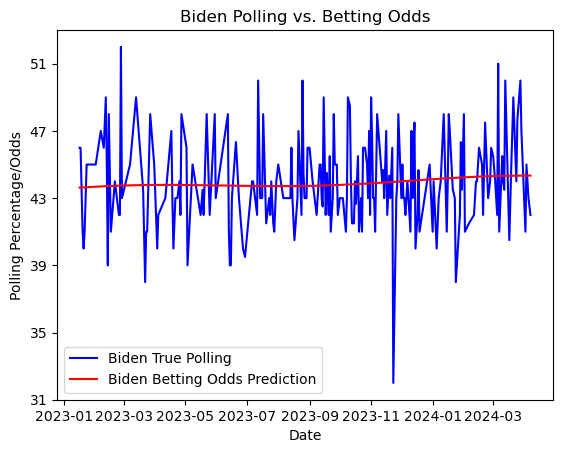

In [14]:
#Plot the results
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(merged["Date"], merged["biden_y"], label='Biden True Polling',color = 'blue')
plt.plot(merged["Date"], y_pred, label='Biden Betting Odds Prediction', color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Biden Polling vs. Betting Odds')
ax.legend()
plt.show()


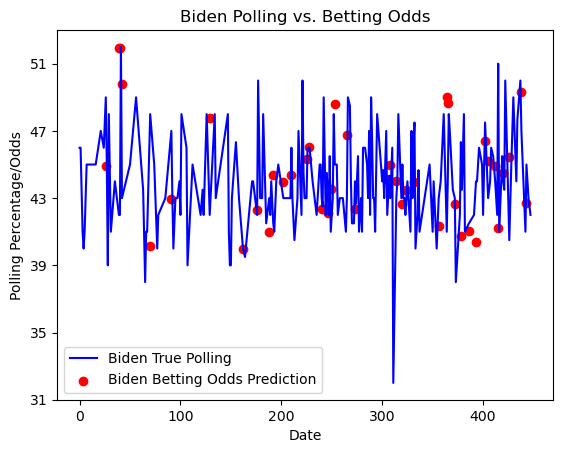

In [15]:
#Try XGBoost instead
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model = XGBRegressor()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)

#Plot the results
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(merged["Days Since Start"], merged["biden_y"], label='Biden True Polling',color = 'blue')
plt.scatter(Xtest["Days Since Start"], y_pred, label='Biden Betting Odds Prediction', color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Biden Polling vs. Betting Odds')
ax.legend()
plt.show()



In [16]:
#Make a new prediction df
X

,Days Since Start,biden_x,SinFreq1,CosFreq1
0,0,25.7,0.000000,1.000000
1,1,26.0,0.017213,0.999852
2,3,25.2,0.051620,0.998667
3,4,25.8,0.068802,0.997630
4,5,25.4,0.085965,0.996298
...,...,...,...,...
209,438,38.6,0.951057,0.309017
210,442,38.8,0.970064,0.242850
211,443,39.0,0.974100,0.226116
212,445,40.6,0.981306,0.192452


## I know a poll is getting released tomorrow. What data do I have right now to predict what that poll is going to say?
- All prior polls that have been released.
- Betting data up to now. 
- How do we assign a date to the polling data? - Assign the date to be the day afterwards. 
- Use betting data, from the last date of the poll. I.e. if the poll ends up on March 12th, then we should be using betting data from march 12th only. 

In [17]:
#Make a linear regression model
model = XGBRegressor()
Xtrain = X[:-1]
ytrain = y[:-1]
Xtest = X[-1:]
ytest = y[-1:]

model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)
y_pred


array([43.05319], dtype=float32)

In [18]:
#Now, we want to add pollster into the mix
betting_polling = pd.merge(rcp, df, left_on="End Date", right_on = "Date", how="inner")
betting_polling.head()

,pollster,date_x,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23,date_y,trump,biden,biden_rolling,trump_rolling,Date
0,Morning Consult,4/5 - 4/7,6236 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6236,2024-04-07,4,2024,462,2024-04-07,43.6,41.0,0.931818,0.909938,2024-04-07
1,Reuters/Ipsos,4/3 - 4/7,833 RV,4.0,37.0,41.0,Biden+4,-4.0,RV,833,2024-04-07,4,2024,462,2024-04-07,43.6,41.0,0.931818,0.909938,2024-04-07
2,I&I/TIPP,4/3 - 4/5,1265 RV,2.8,40.0,43.0,Biden+3,-3.0,RV,1265,2024-04-05,4,2024,460,2024-04-05,43.4,40.6,0.909091,0.903727,2024-04-05
3,Emerson,4/2 - 4/3,1438 RV,2.5,46.0,45.0,Trump+1,1.0,RV,1438,2024-04-03,4,2024,458,2024-04-03,44.3,39.0,0.818182,0.931677,2024-04-03
4,Rasmussen Reports,3/31 - 4/2,1099 LV,3.0,49.0,41.0,Trump+8,8.0,LV,1099,2024-04-02,4,2024,457,2024-04-02,44.5,38.8,0.806818,0.937888,2024-04-02


In [19]:
X = betting_polling[["Days Since 01-01-23", "biden", "trump", "pollster"]].copy()
X["biden"] = X["biden"].astype(float)
X["trump"] = X["trump"].astype(float)
biden_y = betting_polling["Biden (D)"].copy()
trump_y = betting_polling["Trump (R)"].copy()
X = pd.get_dummies(X, drop_first=True)
X.head()

,Days Since 01-01-23,biden,trump,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,...,pollster_Rasmussen Reports,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**
0,462,41.0,43.6,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,462,41.0,43.6,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,460,40.6,43.4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,458,39.0,44.3,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,457,38.8,44.5,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [20]:
#Now we can train the model
biden_model = XGBRegressor()
trump_model = XGBRegressor()
Xtrain = X[:-1]
bidentrain = biden_y[:-1]
trumptrain = trump_y[:-1]

biden_model.fit(Xtrain, bidentrain)
trump_model.fit(Xtrain, trumptrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
#We need to make a new prediction df where the betting data is all the last day, but we have a row for each pollster
#The pollsters should be a diagonal matrix, with one True as the diagonal and the rest False
def make_prediction_df(X):
    col_names = list(X.columns)
    last_day = X.iloc[-1]
    prediction_df = pd.DataFrame(columns = col_names)
    number_of_pollsters = 0
    for col in col_names:
        if "pollster" in col:
            number_of_pollsters += 1

    pollster_names = [col for col in col_names if "pollster" in col]

    for i in range(number_of_pollsters):
        row = np.zeros(number_of_pollsters)
        row[i] = 1
        prediction_df[pollster_names[i]] = row

    prediction_df["Days Since 01-01-23"] = last_day["Days Since 01-01-23"]
    prediction_df["biden"] = last_day["biden"]
    prediction_df["trump"] = last_day["trump"]
    return prediction_df

prediction_df = make_prediction_df(X)
prediction_df.head()

,Days Since 01-01-23,biden,trump,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,...,pollster_Rasmussen Reports,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**
0,243,34.4,27.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,243,34.4,27.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,243,34.4,27.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,243,34.4,27.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,243,34.4,27.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Make a prediction
biden_pred = biden_model.predict(prediction_df)
trump_pred = trump_model.predict(prediction_df)
#Make a good dataframe to display predictions

pollster_names = [col for col in X.columns if "pollster" in col]
today = datetime.today()
tomorrow = today + timedelta(days=1)
tomorrow_string = tomorrow.strftime('%Y-%m-%d')

pollster_predictions = pd.DataFrame({"Pollster": pollster_names, "Biden Prediction: " + tomorrow_string: biden_pred, "Trump Prediction: " + tomorrow_string: trump_pred})
pollster_predictions

,Pollster,Biden Prediction: 2024-04-12,Trump Prediction: 2024-04-12
0,pollster_CBS News,48.978191,48.969704
1,pollster_CNBC,44.849033,45.266071
2,pollster_CNN,45.989677,47.200813
3,pollster_Daily Kos/Civiqs,45.235352,44.285320
4,pollster_Data for Progress (D)**,46.192715,44.157028
5,pollster_Economist/YouGov,43.664978,43.978340
6,pollster_Emerson,43.878723,45.707630
7,pollster_FOX News,44.773205,47.411476
8,pollster_Federalist/Susquehanna,48.047199,44.539001
9,pollster_Forbes/HarrisX,47.482998,49.261715


In [23]:
#Now we want to make a long running CSV file that we can append to

#First, we need to make a function that takes in the current data and the new prediction and appends it to the CSV file
#There is a bug here 
def append_to_csv(pollster_predictions, filename):
    try:
        old_data = pd.read_csv(filename)
    except:
        old_data = pd.DataFrame(columns = pollster_predictions.columns)
    #Maybe try to do a merge instead
    if "Biden Prediction: " + tomorrow_string not in old_data.columns:
        #Really we want to do a right join here
        new_data = pd.merge(old_data, pollster_predictions, how = 'right', on = "Pollster")
        new_data.to_csv(filename, index=False)
    else:
        print("Already added today!")

append_to_csv(pollster_predictions, "Datasets/betting_predictions.csv")

In [24]:
pollster_predictions

,Pollster,Biden Prediction: 2024-04-12,Trump Prediction: 2024-04-12
0,pollster_CBS News,48.978191,48.969704
1,pollster_CNBC,44.849033,45.266071
2,pollster_CNN,45.989677,47.200813
3,pollster_Daily Kos/Civiqs,45.235352,44.285320
4,pollster_Data for Progress (D)**,46.192715,44.157028
5,pollster_Economist/YouGov,43.664978,43.978340
6,pollster_Emerson,43.878723,45.707630
7,pollster_FOX News,44.773205,47.411476
8,pollster_Federalist/Susquehanna,48.047199,44.539001
9,pollster_Forbes/HarrisX,47.482998,49.261715
